# The Cameron Peak Fire, Colorado, USA

<img style="float: left; padding-right: 3em;" src="https://pbs.twimg.com/profile_images/1537109064093532160/mG03dW9G_400x400.jpg" width="150" />

## It’s another ESIIL Earth Data Science Workflow

This notebook contains your next environmental data science (EDS) coding
challenge! Before we get started, make sure to read or review the
guidelines below. These will help make sure that your code is *readable*
and *reproducible*.

------------------------------------------------------------------------

### Don’t get **caught** by these interactive coding notebook gotchas

<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*o0HleR7BSe8W-pTnmucqHA.jpeg" height="300" style="padding: 1em; border-style: solid; border-color: grey;"/>

> *Image source:
> https://alaskausfws.medium.com/whats-big-and-brown-and-loves-salmon-e1803579ee36*

These are the most common issues that will keep you from getting started
and delay your code review:

### Run your code in the right **environment** to avoid import errors

We’ve created a coding **environment** for you to use that already has
all the software and libraries you will need! When you try to run some
code, you may be prompted to select a **kernel**. The **kernel** refers
to the version of Python you are using. You should use the **base**
kernel, which should be the default option.

### Always run your code start to finish before submitting

Before you commit your work, make sure it runs **reproducibly** by
clicking:

1.  `Restart` (this button won’t appear until you’ve run some code),
    then
2.  `Run All`

### **Check your code to make sure it’s clean and easy to read**

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSO1w9WrbwbuMLN14IezH-iq2HEGwO3JDvmo5Y_hQIy7k-Xo2gZH-mP2GUIG6RFWL04X1k&amp;usqp=CAU" height="200"/>

-   Format all cells prior to submitting (right click on your code).

-   Use expressive names for variables so you or the reader knows what
    they are.

-   Use comments to explain your code – e.g.

    ``` python
    # This is a comment, it starts with a hash sign
    ```

### **Label and describe your plots**

<figure>
<img src="https://imgs.xkcd.com/comics/convincing.png"
alt="Source: https://xkcd.com/833" />
<figcaption aria-hidden="true">Source: https://xkcd.com/833</figcaption>
</figure>

Make sure each plot has:

-   A title that explains where and when the data are from
-   x- and y- axis labels with **units** where appropriate
-   A legend where appropriate

------------------------------------------------------------------------

The Cameron Peak Fire was the largest fire in Colorado history, with 326
square miles burned.

## Observing vegetation health from space

We will look at the destruction and recovery of vegetation using NDVI
(Normalized Difference Vegetation Index). How does it work? First, we
need to learn about spectral reflectance signatures.

Every object reflects some wavelengths of light more or less than
others. We can see this with our eyes, since, for example, plants
reflect a lot of green in the summer, and then as that green diminishes
in the fall they look more yellow or orange. The image below shows
spectral signatures for water, soil, and vegetation:

![](https://seos-project.eu/remotesensing/images/Reflexionskurven.jpg)
\> Image source: [SEOS
Project](https://seos-project.eu/remotesensing/remotesensing-c01-p06.html)

Healthy vegetation reflects a lot of Near-InfraRed (NIR) radiation. Dead
ve Less healthy vegetation reflects a similar amounts of the visible
light spectra, but less NIR radiation. We don’t see a huge drop in Green
radiation until the plant is very stressed or dead. That means that NIR
allows us to get ahead of what we can see with our eyes.

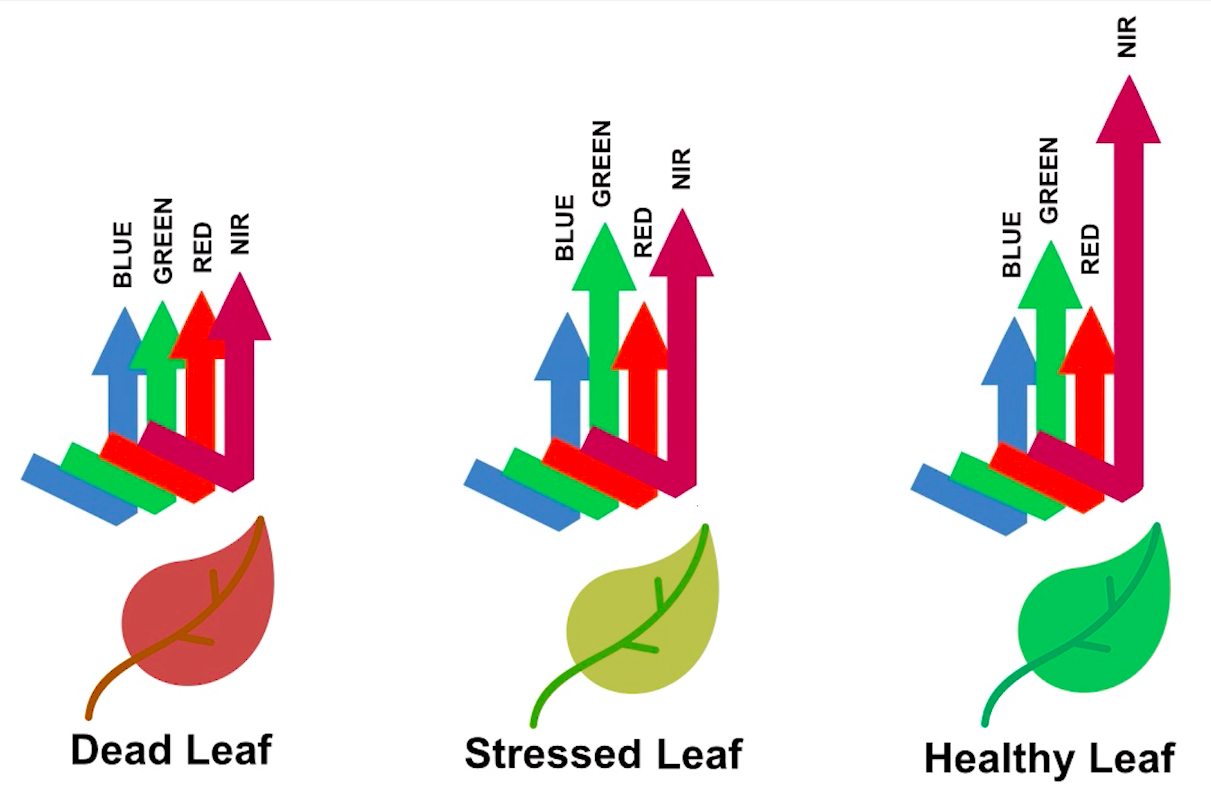
\> Image source: [Spectral signature literature review by
px39n](https://github.com/px39n/Awesome-Vegetation-Index)

Different species of plants reflect different spectral signatures, but
the *pattern* of the signatures are similar. NDVI compares the amount of
NIR reflectance to the amount of Red reflectance, thus accounting for
many of the species differences and isolating the health of the plant.
The formula for calculating NDVI is:

$$NDVI = \frac{(NIR - Red)}{(NIR + Red)}$$

Read more about NDVI and other vegetation indices: \*
[earthdatascience.org](https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/vegetation-indices-in-python/calculate-NDVI-python/)
\*
[USGS](https://www.usgs.gov/landsat-missions/landsat-surface-reflectance-derived-spectral-indices)

> **<i class="fa fa-solid fa-fa-keyboard" aria-label="fa-keyboard"></i>
> Import necessary libraries**
>
> In the cell below, making sure to keep the packages in order, add
> packages for:
>
> -   Working with DataFrames
> -   Working with GeoDataFrames
>
> <i class="fa fa-solid fa-fa-circle-question" aria-label="fa-circle-question"></i>
> What are we using the rest of these packages for? See if you can
> figure it out as you complete the notebook.

In [ ]:
# Install the development version of the earthpy package
!pip install git+https://github.com/earthlab/earthpy@apppears

In [25]:
# Import python libraries
import getpass
import json
import os
import pathlib
from glob import glob

# Library to work with tabular data
import pandas as pd

# Library to work with vector data
import geopandas as gpd

import earthpy.appeears as eaapp
import hvplot.pandas 
import hvplot.xarray
import rioxarray as rxr
import xarray as xr # uses numpy

We have one more setup task. We’re not going to be able to load all our
data directly from the web to Python this time. That means we need to
set up a place for it.

> **<i class="fa fa-solid fa-exclamation fa-large" aria-label="exclamation"></i>
> GOTCHA ALERT**
>
> A lot of times in Python we say “directory” to mean a “folder” on your
> computer. The two words mean the same thing in this context.

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your task**
>
> In the cell below, replace ‘my-data-folder’ with a **descriptive**
> directory name.

In [6]:
data_dir = os.path.join(pathlib.Path.home(), 'cameron-peak-data')
# Make the data directory
os.makedirs(data_dir, exist_ok=True)

data_dir

'/home/jovyan/cameron-peak-data'

## Study Area: Cameron Peak Fire Boundary

### Earth Data Science data formats

In Earth Data Science, we get data in three main formats:

| Data type   | Descriptions                                                              | Common file formats                                                                                              | Python type            |
|----------------|------------------|------------------------|----------------|
| Time Series | The same data points (e.g. streamflow) collected multiple times over time | Tabular formats (e.g. .csv, or .xlsx)                                                                            | pandas DataFrame       |
| Vector      | Points, lines, and areas (with coordinates)                               | Shapefile (often an archive like a `.zip` file because a Shapefile is actually a collection of at least 3 files) | geopandas GeoDataFrame |
| Raster      | Evenly spaced spatial grid (with coordinates)                             | GeoTIFF (`.tif`), NetCDF (`.nc`), HDF (`.hdf`)                                                                   | rioxarray DataArray    |

> **<i class="fa fa-solid fa-glasses fa-large" aria-label="glasses"></i>
> Read more**
>
> Check out the sections about about [vector
> data](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/spatial-data-vector-shapefiles/)
> and [raster
> data](https://www.earthdatascience.org/courses/intro-to-earth-data-science/file-formats/use-spatial-data/use-raster-data/)
> in the textbook.

> **<i class="fa fa-solid fa-pencil fa-large" aria-label="pencil"></i>
> What do you think?**
>
> For this coding challenge, we are interested in the boundary of the
> Cameron Peak Fire. In the cell below, answer the following question:
> **What data type do you think the reservation boundaries will be?**

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your task:**
>
> -   **Search** the [National Interagency Fire Center Wildfire Boundary
>     catalog](https://data-nifc.opendata.arcgis.com/datasets/5e72b1699bf74eefb3f3aff6f4ba5511_0/api)
>     for and incident name “Cameron Peak”
> -   Copy the API results to your clipboard.
> -   **Load the data into Python** using the `geopandas` library, e.g.:
>     `python      gpd.read_file(url)`
> -   **Call** your data at the end of the cell for testing.

In [4]:
# Download the Cameron Peak fire boundary
cameron_peak_url = ("https://services3.arcgis.com/T4QMspbfLg3qTGWY/"
                    "arcgis/rest/services/WFIGS_Interagency_Perimeters/"
                    "FeatureServer/0/"
                    "query?where=poly_IncidentName%20%3D%20'CAMERON%20PEAK'&"
                    "outFields=*&outSR=4326&f=json")
cameron_peak_url

# Open data with geopandas
cameron_peak_gdf = gpd.read_file(cameron_peak_url)
cameron_peak_gdf


,OBJECTID,poly_SourceOID,poly_IncidentName,poly_FeatureCategory,poly_MapMethod,poly_GISAcres,poly_CreateDate,poly_DateCurrent,poly_PolygonDateTime,poly_IRWINID,...,attr_ModifiedOnDateTime_dt,attr_Source,attr_IsCpxChild,attr_CpxName,attr_CpxID,attr_SourceGlobalID,GlobalID,Shape__Area,Shape__Length,geometry
0,14659,10393,Cameron Peak,Wildfire Final Fire Perimeter,Infrared Image,208913.3,NaN,1678806822810,1602019800000,{53741A13-D269-4CD5-AF91-02E094B944DA},...,1638820092647,FODR,NaN,NaN,NaN,{5F5EC9BA-5F85-495B-8B97-1E0969A1434E},e8e4ffd4-db84-4d47-bd32-d4b0a8381fff,0.089957,5.541765,"MULTIPOLYGON (((-105.88333 40.54598, -105.8837..."


In [10]:
ans_gdf = _
gdf_pts = 0

if isinstance(ans_gdf, gpd.GeoDataFrame):
    print('\u2705 Great work! You downloaded and opened a GeoDataFrame')
    gdf_pts +=2
else:
    print('\u274C Hmm, your answer is not a GeoDataFrame')

print('\u27A1 You earned {} of 2 points for downloading data'.format(gdf_pts))

✅ Great work! You downloaded and opened a GeoDataFrame
➡ You earned 2 of 2 points for downloading data


### Site Map

We always want to create a site map when working with geospatial data.
This helps us see that we’re looking at the right location, and learn
something about the context of the analysis.

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your task**
>
> -   Plot your Cameron Peak Fire shapefile on an interactive map
> -   Make sure to add a title
> -   Add ESRI World Imagery as the basemap/background using the
>     `tiles=...` parameter

In [4]:
# Plot the Cameron Peak Fire boundary
cameron_peak_gdf.explore()

## Exploring the AppEEARS API for NASA Earthdata access

Over the next four cells, you will download MODIS NDVI data for the
study period. MODIS is a multispectral instrument that measures Red and
NIR data (and so can be used for NDVI). There are two MODIS sensors on
two different platforms: satellites Terra and Aqua.

> **<i class="fa fa-solid fa-glasses fa-large" aria-label="glasses"></i>
> Read more**
>
> [Learn more about MODIS datasets and the science they
> support](https://modis.gsfc.nasa.gov/)

Since we’re asking for a special download that only covers our study
area, we can’t just find a link to the data - we have to negotiate with
the data server. We’re doing this using the
[APPEEARS](https://appeears.earthdatacloud.nasa.gov/api/) API
(Application Programming Interface). The API makes it possible for you
to request data using code. You can use code from the `earthpy` library
to handle the API request.

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your task**
>
> Often when we want to do something more complex in coding we find an
> example and modify it. This download code is already almost a working
> example. Your task will be:
>
> -   Enter your NASA Earthdata username and password when prompted
> -   Replace the start and end dates in the task parameters. Download
>     data from July, when greenery is at its peak in the Northern
>     Hemisphere.
> -   Replace the year range. You should get 3 years before and after
>     the fire so you can see the change!
> -   Replace `gdf` with the name of **your** site geodataframe.
>
> <i class="fa fa-solid fa-circle-question fa-large" aria-label="circle-question"></i>
> What would the product and layer name be if you were trying to
> download Landsat Surface Temperature Analysis Ready Data (ARD) instead
> of MODIS NDVI?

In [12]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = eaapp.AppeearsDownloader(
    download_key='cp-ndvi',
    ea_dir=data_dir,
    product='MOD13Q1.061',
    layer='_250m_16_days_NDVI',
    start_date="07-01",
    end_date="07-31",
    recurring=True,
    year_range=[2018, 2023],
    polygon=cameron_peak_gdf
)

ndvi_downloader.download_files(cache=True)

## Putting it together: Working with multi-file raster datasets in Python

Now you need to load all the downloaded files into Python. Let’s start
by getting all the file names. You will also need to extract the date
from the filename. Check out [the lesson on getting information from
filenames in the
textbook](https://www.earthdatascience.org/courses/intro-to-earth-data-science/write-efficient-python-code/loops/data-workflows-with-loops/).

> **<i class="fa fa-solid fa-exclamation fa-large" aria-label="exclamation"></i>
> GOTCHA ALERT**
>
> `glob` doesn’t necessarily find files in the order you would expect.
> Make sure to **sort** your file names like it says in the textbook.

In [7]:
# Get a list of NDVI tif file paths
ndvi_paths = sorted(glob(os.path.join(data_dir, 'cp-ndvi', '*', '*NDVI*.tif')))
len(ndvi_paths)

18

### Repeating tasks in Python

Now you should have a few dozen files! For each file, you need to:

-   Load the file in using the `rioxarray` library
-   Get the date from the file name
-   Add the date as a dimension coordinate
-   Give your data variable a name
-   Divide by the scale factor of 10000

You don’t want to write out the code for each file! That’s a recipe for
copy pasta. Luckily, Python has tools for doing similar tasks
repeatedly. In this case, you’ll use one called a `for` loop.

There’s some code below that uses a `for` loop in what is called an
**accumulation pattern** to process each file. That means that you will
save the results of your processing to a list each time you process the
files, and then merge all the arrays in the list.

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your task**
>
> -   Look at the file names. How many characters from the end is the
>     date?
> -   Replace any required variable names with your chosen variable
>     names
> -   Change the `scale_factor` variable to be the correct scale factor
>     for this NDVI dataset (HINT: NDVI should range between 0 and 1)
> -   Using indices or regular

In [18]:
scale_factor = 10000
doy_start = -19
doy_end = -12

In [19]:
ndvi_das = []
for ndvi_path in ndvi_paths:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Multiple by scale factor
    da = da / scale_factor

    # Prepare for concatenation
    ndvi_das.append(da)

len(ndvi_das)

18

In [20]:
ndvi_das

[<xarray.DataArray 'NDVI' (date: 1, y: 153, x: 339)>
 array([[[0.5672, 0.5711, 0.6027, ..., 0.3888, 0.3888, 0.381 ],
         [0.5793, 0.6917, 0.6917, ..., 0.3902, 0.3683, 0.381 ],
         [0.6174, 0.6174, 0.6917, ..., 0.3867, 0.3902, 0.4094],
         ...,
         [0.2816, 0.2816, 0.1774, ..., 0.4708, 0.3777, 0.4174],
         [0.2966, 0.2966, 0.2701, ..., 0.3807, 0.4774, 0.4307],
         [0.363 , 0.2543, 0.2701, ..., 0.3878, 0.4797, 0.4797]]],
       dtype=float32)
 Coordinates:
     band         int64 1
   * x            (x) float64 -105.9 -105.9 -105.9 ... -105.2 -105.2 -105.2
   * y            (y) float64 40.78 40.78 40.77 40.77 ... 40.47 40.47 40.46 40.46
     spatial_ref  int64 0
   * date         (date) datetime64[ns] 2018-06-26,
 <xarray.DataArray 'NDVI' (date: 1, y: 153, x: 339)>
 array([[[0.5806, 0.5789, 0.5865, ..., 0.3451, 0.3451, 0.3483],
         [0.5633, 0.6341, 0.6341, ..., 0.3777, 0.3484, 0.3483],
         [0.6144, 0.6144, 0.6309, ..., 0.3511, 0.3484, 0.3376],
    

Next, stack your arrays by date into a time series using the
`xr.combine_by_coords()` function. You will have to tell it which
dimension you want to stack your data in.

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Plot the change in NDVI spatially**
>
> Complete the following: \* Select data from 2021 to 2023 (3 years
> after the fire) \* Take the temporal mean (over the **date**, not
> spatially) \* Get the NDVI variable (should be a DataArray, not a
> Dataset) \* Repeat for the data from 2018 to 2020 (3 years before the
> fire) \* Subtract the 2018-2020 time period **from** the 2021-2023
> time period \* Plot the result using a **diverging** color map like
> `cmap=plt.cm.PiYG`
>
> > There are different types of color maps for different types of data.
> > In this case, we want decreases to be a different color from
> > increases, so we should use a **diverging** color map. Check out
> > available colormaps in the [matplotlib
> > documentation](https://matplotlib.org/stable/tutorials/colors/colormaps.html).
>
> <i class="fa fa-solid fa-pepper-hot fa-large" aria-label="pepper-hot"></i>
> For an extra challenge, add the fire boundary to the plot

In [21]:
ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])
ndvi_da

<xarray.Dataset>
Dimensions:      (x: 339, y: 153, date: 18)
Coordinates:
    band         int64 1
  * x            (x) float64 -105.9 -105.9 -105.9 ... -105.2 -105.2 -105.2
  * y            (y) float64 40.78 40.78 40.77 40.77 ... 40.47 40.47 40.46 40.46
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2018-06-26 2018-07-12 ... 2023-07-28
Data variables:
    NDVI         (date, y, x) float32 0.5672 0.5711 0.6027 ... 0.6327 0.6327

In [27]:
import matplotlib.pyplot as plt

In [ ]:
# Compute the difference in NDVI before and after the fire
ndvi_diff = (
    ndvi_da
        .sel(date=slice('2021', '2023'))
        .mean('date')
        .NDVI 
   - ndvi_da
        .sel(date=slice('2018', '2020'))
        .mean('date')
        .NDVI
)

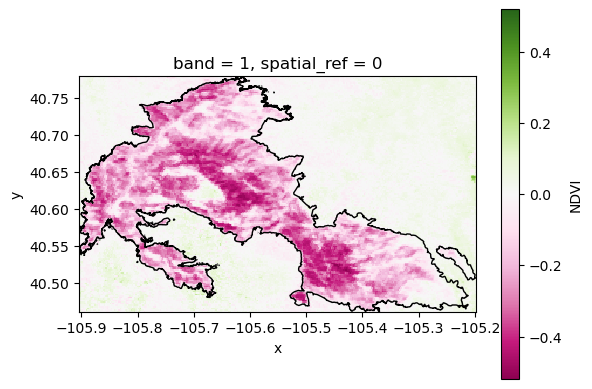

In [28]:
# Plot the difference
fig, ax = plt.subplots()

ndvi_diff.plot(x='x', y='y', cmap='PiYG', ax=ax)
cameron_peak_gdf.plot(edgecolor='black', color='none', ax=ax)
plt.show()

# Is the NDVI lower within the fire boundary after the fire?

You will compute the mean NDVI inside and outside the fire boundary.
First, use the code below to get a `GeoDataFrame` of the area outside
the Reservation. Your task: \* Check the variable names - Make sure that
the code uses your boundary `GeoDataFrame` \* How could you test if the
geometry was modified correctly? Add some code to take a look at the
results.

In [30]:
out_gdf = (
    gpd.GeoDataFrame(geometry=cameron_peak_gdf.envelope)
    .overlay(cameron_peak_gdf, how='difference'))
out_gdf

,geometry
0,"MULTIPOLYGON (((-105.90371 40.46134, -105.9037..."


Next, clip your DataArray to the boundaries for both inside and outside
the reservation. You will need to replace the `GeoDataFrame` name with
your own. Check out the [lesson on clipping data with the `rioxarray`
library in the
textbook](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/).

> **<i class="fa fa-solid fa-exclamation fa-large" aria-label="exclamation"></i>
> GOTCHA ALERT**
>
> It’s important to use `from_disk=True` when clipping large arrays like
> this. It allows the computer to use less valuable memory resources
> when clipping - you will probably find that otherwise the cell below
> crashes the kernel

In [32]:
# Clip data to both inside and outside the boundary
ndvi_cp_da = ndvi_da.rio.clip(cameron_peak_gdf.geometry, from_disk=True)
ndvi_out_da = ndvi_da.rio.clip(out_gdf.geometry, from_disk=True)

> **<i class="fa fa-solid fa-keyboard fa-large" aria-label="keyboard"></i>
> Your Task**
>
> For **both inside and outside** the fire boundary:
>
> -   Group the data by year
> -   Take the mean. You always need to tell reducing methods in
>     `xarray` what dimensions you want to reduce. When you want to
>     summarize data across **all** dimensions, you can use the `...`
>     syntax, e.g. `.mean(...)` as a shorthand.
> -   Select the NDVI variable
> -   Convert to a DataFrame using the `to_dataframe()` method
> -   Join the two DataFrames for plotting using the `.join()` method.
>     You will need to rename the columns using the `lsuffix=` and
>     `rsuffix=` parameters

> **<i class="fa fa-solid fa-exclamation fa-large" aria-label="exclamation"></i>
> GOTCHA ALERT**
>
> The DateIndex in pandas is a little different from the Datetime
> Dimension in xarray. You will need to use the `.dt.year` syntax to
> access information about the year, not just `.year`.

Finally, plot annual July means for both inside and outside the
Reservation on the same plot.

:::

In [33]:
# Compute mean annual July NDVI
jul_ndvi_cp_df = (
    ndvi_cp_da
    .groupby(ndvi_cp_da.date.dt.year)
    .mean(...)
    .NDVI.to_dataframe())
jul_ndvi_out_df = (
    ndvi_out_da
    .groupby(ndvi_out_da.date.dt.year)
    .mean(...)
    .NDVI.to_dataframe())

# Plot inside and outside the reservation
jul_ndvi_df = (
    jul_ndvi_cp_df[['NDVI']]
    .join(
        jul_ndvi_out_df[['NDVI']], 
        lsuffix=' Burned Area', rsuffix=' Unburned Area')
)

Now, take the difference between outside and inside the Reservation and
plot that. What do you observe? Don’t forget to write a headline and
description of your plot!

<Axes: title={'center': 'NDVI before and after the Cameron Peak Fire'}, xlabel='year'>

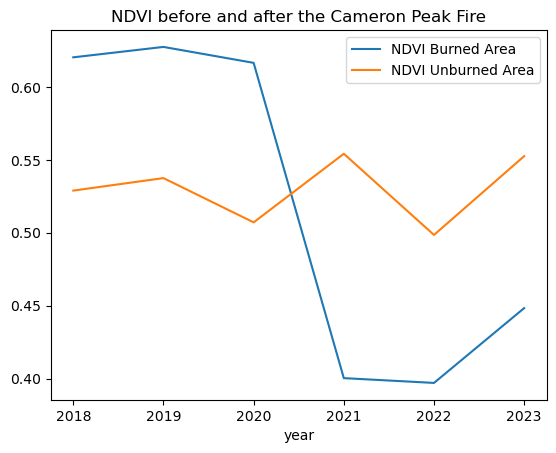

In [35]:
# Plot difference inside and outside the reservation
jul_ndvi_df.plot(
    title='NDVI before and after the Cameron Peak Fire')

## Your turn! Repeat this workflow in a different time and place.

It’s not just fires that affect NDVI! You could look at:

-   Recovery after a national disaster, like a wildfire or hurricane
-   Drought
-   Deforestation
-   Irrigation
-   Beaver reintroduction

***

### Looking at Lagos, Nigeria

In [41]:
lagos_dir = os.path.join(pathlib.Path.home(), 'lagos-data')
# Make the data directory
os.makedirs(lagos_dir, exist_ok=True)

lagos_dir

'/home/jovyan/lagos-data'

In [36]:
# Define url to Nigeria .shp
nigeria_url = "https://open.africa/dataset/83582021-d8f7-4bfd-928f-e9c6c8cb1247/resource/372a616a-66cc-41f7-ac91-d8af8f23bc2b/download/nigeria-lgas.zip"

# Open Nigeria .shp using geopandas
nigeria_gdf = gpd.read_file(nigeria_url)
nigeria_gdf

,STATE,LGA,AREA,PERIMETER,LONGITUDE,LATITUDE,FULL_NAME,geometry
0,Sokoto,Gada,1193.977,170.095,NaN,NaN,NaN,"POLYGON ((5.53632 13.88793, 5.53480 13.88488, ..."
1,Sokoto,Illela,1298.423,174.726,NaN,NaN,NaN,"POLYGON ((5.53632 13.88793, 5.54517 13.88419, ..."
2,Sokoto,Tangaza,2460.715,209.702,NaN,NaN,NaN,"POLYGON ((4.85548 13.76724, 4.86189 13.78085, ..."
3,Borno,Abadam,2430.515,288.957,NaN,NaN,NaN,"POLYGON ((12.83189 13.39871, 12.83397 13.40439..."
4,Lake,Lake chad,5225.912,497.039,NaN,NaN,NaN,"POLYGON ((13.48608 13.30821, 13.48296 13.31344..."
...,...,...,...,...,...,...,...,...
770,Delta,Isoko North,485.467,169.369,NaN,NaN,NaN,"MULTIPOLYGON (((6.31996 5.63341, 6.32003 5.633..."
771,Niger,Lavun,3951.431,424.153,NaN,NaN,NaN,"MULTIPOLYGON (((6.12188 9.09441, 6.12001 9.094..."
772,Yobe,Bade,817.260,216.207,NaN,NaN,NaN,"MULTIPOLYGON (((11.01052 12.80457, 11.00747 12..."
773,Zamfara,Maru,7795.261,536.500,NaN,NaN,NaN,"MULTIPOLYGON (((6.43894 12.41104, 6.43609 12.4..."


In [37]:
# Select out Lagos
lagos = nigeria_gdf[nigeria_gdf["STATE"]=="Lagos"]
lagos

,STATE,LGA,AREA,PERIMETER,LONGITUDE,LATITUDE,FULL_NAME,geometry
542,Lagos,Ifako/Ijaye,33.615,28.115,NaN,NaN,NaN,"POLYGON ((3.26599 6.70696, 3.26787 6.70693, 3...."
543,Lagos,Alimosho,148.062,55.194,NaN,NaN,NaN,"POLYGON ((3.28961 6.67267, 3.28807 6.66979, 3...."
546,Lagos,Ikorodu,369.494,88.090,NaN,NaN,NaN,"POLYGON ((3.69866 6.68905, 3.69502 6.68524, 3...."
549,Lagos,Agege,16.575,18.782,NaN,NaN,NaN,"POLYGON ((3.33228 6.64879, 3.33108 6.64763, 3...."
551,Lagos,Ikeja,45.744,32.736,NaN,NaN,NaN,"POLYGON ((3.35382 6.66920, 3.35453 6.66877, 3...."
554,Lagos,Kosofe,74.118,38.369,NaN,NaN,NaN,"POLYGON ((3.43208 6.64850, 3.43255 6.64591, 3...."
558,Lagos,Lagos Island,238.990,94.966,NaN,NaN,NaN,"POLYGON ((3.46255 6.60946, 3.46357 6.60944, 3...."
560,Lagos,Oshodi/Isolo,38.595,28.349,NaN,NaN,NaN,"POLYGON ((3.33961 6.58872, 3.34026 6.58733, 3...."
561,Lagos,Shomolu,18.304,17.122,NaN,NaN,NaN,"POLYGON ((3.38974 6.57181, 3.39050 6.57035, 3...."
562,Lagos,Mushin,17.387,18.422,NaN,NaN,NaN,"POLYGON ((3.36006 6.57612, 3.36123 6.57177, 3...."


In [38]:
# Interactive map of Lagos
lagos.explore()

In [39]:
# Select Alimosho
alimosho = lagos[lagos["LGA"]=='Alimosho']
alimosho

,STATE,LGA,AREA,PERIMETER,LONGITUDE,LATITUDE,FULL_NAME,geometry
543,Lagos,Alimosho,148.062,55.194,NaN,NaN,NaN,"POLYGON ((3.28961 6.67267, 3.28807 6.66979, 3...."


In [40]:
alimosho.explore()

In [42]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = eaapp.AppeearsDownloader(
    download_key='lagos-ndvi',
    ea_dir=lagos_dir,
    product='MOD13Q1.061',
    layer='_250m_16_days_NDVI',
    start_date="07-01",
    end_date="07-31",
    recurring=True,
    year_range=[2015, 2020],
    polygon=alimosho
)

ndvi_downloader.download_files(cache=True)

In [44]:
# Get a list of NDVI tif file paths
lagos_paths = sorted(glob(os.path.join(lagos_dir, 'lagos-ndvi', '*', '*NDVI*.tif')))
len(lagos_paths)

18

In [45]:
lagos_das = []
for lagos_path in lagos_paths:
    # Get date from file name
    doy = lagos_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open dataset
    da = rxr.open_rasterio(lagos_path, masked=True).squeeze()

    # Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Multiple by scale factor
    da = da / scale_factor

    # Prepare for concatenation
    lagos_das.append(da)

len(lagos_das)

18

In [46]:
lagos_da = xr.combine_by_coords(lagos_das, coords=['date'])
lagos_da

<xarray.Dataset>
Dimensions:      (x: 56, y: 89, date: 18)
Coordinates:
    band         int64 1
  * x            (x) float64 3.186 3.189 3.191 3.193 ... 3.295 3.297 3.299 3.301
  * y            (y) float64 6.705 6.703 6.701 6.699 ... 6.528 6.526 6.524 6.522
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2015-06-26 2015-07-12 ... 2020-07-27
Data variables:
    NDVI         (date, y, x) float32 0.6021 0.6098 0.5921 ... 0.2961 0.297

In [47]:
# Compute the difference in NDVI before and after the fire
lagos_diff = (
    lagos_da
        .sel(date=slice('2017', '2020'))
        .mean('date')
        .NDVI 
   - lagos_da
        .sel(date=slice('2015', '2017'))
        .mean('date')
        .NDVI
)

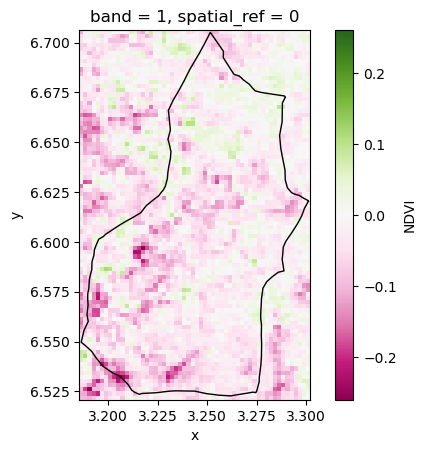

In [48]:
# Plot the difference
fig, ax = plt.subplots()

lagos_diff.plot(x='x', y='y', cmap='PiYG', ax=ax)
alimosho.plot(edgecolor='black', color='none', ax=ax)
plt.show()

In [49]:
alimosho_out_gdf = (
    gpd.GeoDataFrame(geometry=alimosho.envelope)
    .overlay(alimosho, how='difference'))
alimosho_out_gdf

,geometry
0,"MULTIPOLYGON (((3.18644 6.52276, 3.18644 6.549..."


In [50]:
# Clip data to both inside and outside the boundary
ndvi_lagos_da = lagos_da.rio.clip(alimosho.geometry, from_disk=True)
ndvi_lagos_out_da = lagos_da.rio.clip(alimosho_out_gdf.geometry, from_disk=True)

In [51]:
# Compute mean annual July NDVI
jul_ndvi_lagos_df = (
    ndvi_lagos_da
    .groupby(ndvi_lagos_da.date.dt.year)
    .mean(...)
    .NDVI.to_dataframe())
jul_ndvi_lagos_out_df = (
    ndvi_lagos_out_da
    .groupby(ndvi_lagos_out_da.date.dt.year)
    .mean(...)
    .NDVI.to_dataframe())

# Plot inside and outside the reservation
lagos_jul_ndvi_df = (
    jul_ndvi_lagos_df[['NDVI']]
    .join(
        jul_ndvi_lagos_out_df[['NDVI']], 
        lsuffix=' Burned Area', rsuffix=' Unburned Area')
)

<Axes: title={'center': 'NDVI before and after 2017; Alimosho, Lagos, Nigeria'}, xlabel='year'>

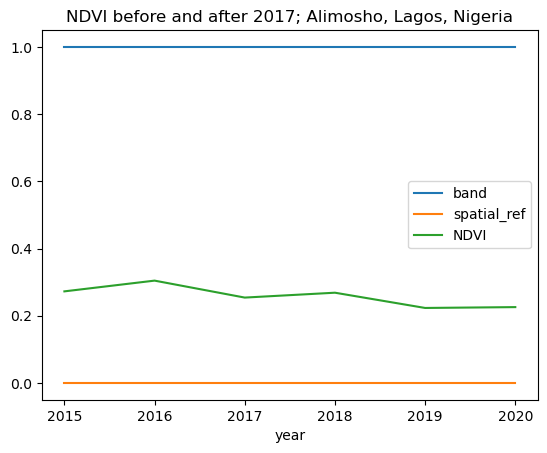

In [52]:
# Plot difference inside and outside the reservation
jul_ndvi_lagos_df.plot(
    title='NDVI before and after 2017; Alimosho, Lagos, Nigeria')